# Creating a Test System 

This is the 5 bus system for ED and OPF from the text book of Glover et al., Example 6.20 

J. D. Glover, M. S. Sarma, and T. J. Overbye, Power System Analysis and Design, 5th ed. Stamford, CT: Cengage Learning, 2012.

It is almost similar to this 5-bus system from Glenn W. Stagg, and Ahmed H. El-Abiad, Computer Methods in Power System Analysis, 9th ed. Tokyo, Japan: McGraw-Hill, 1983.
https://www.al-roomi.org/power-flow/5-bus-systems/system-iii



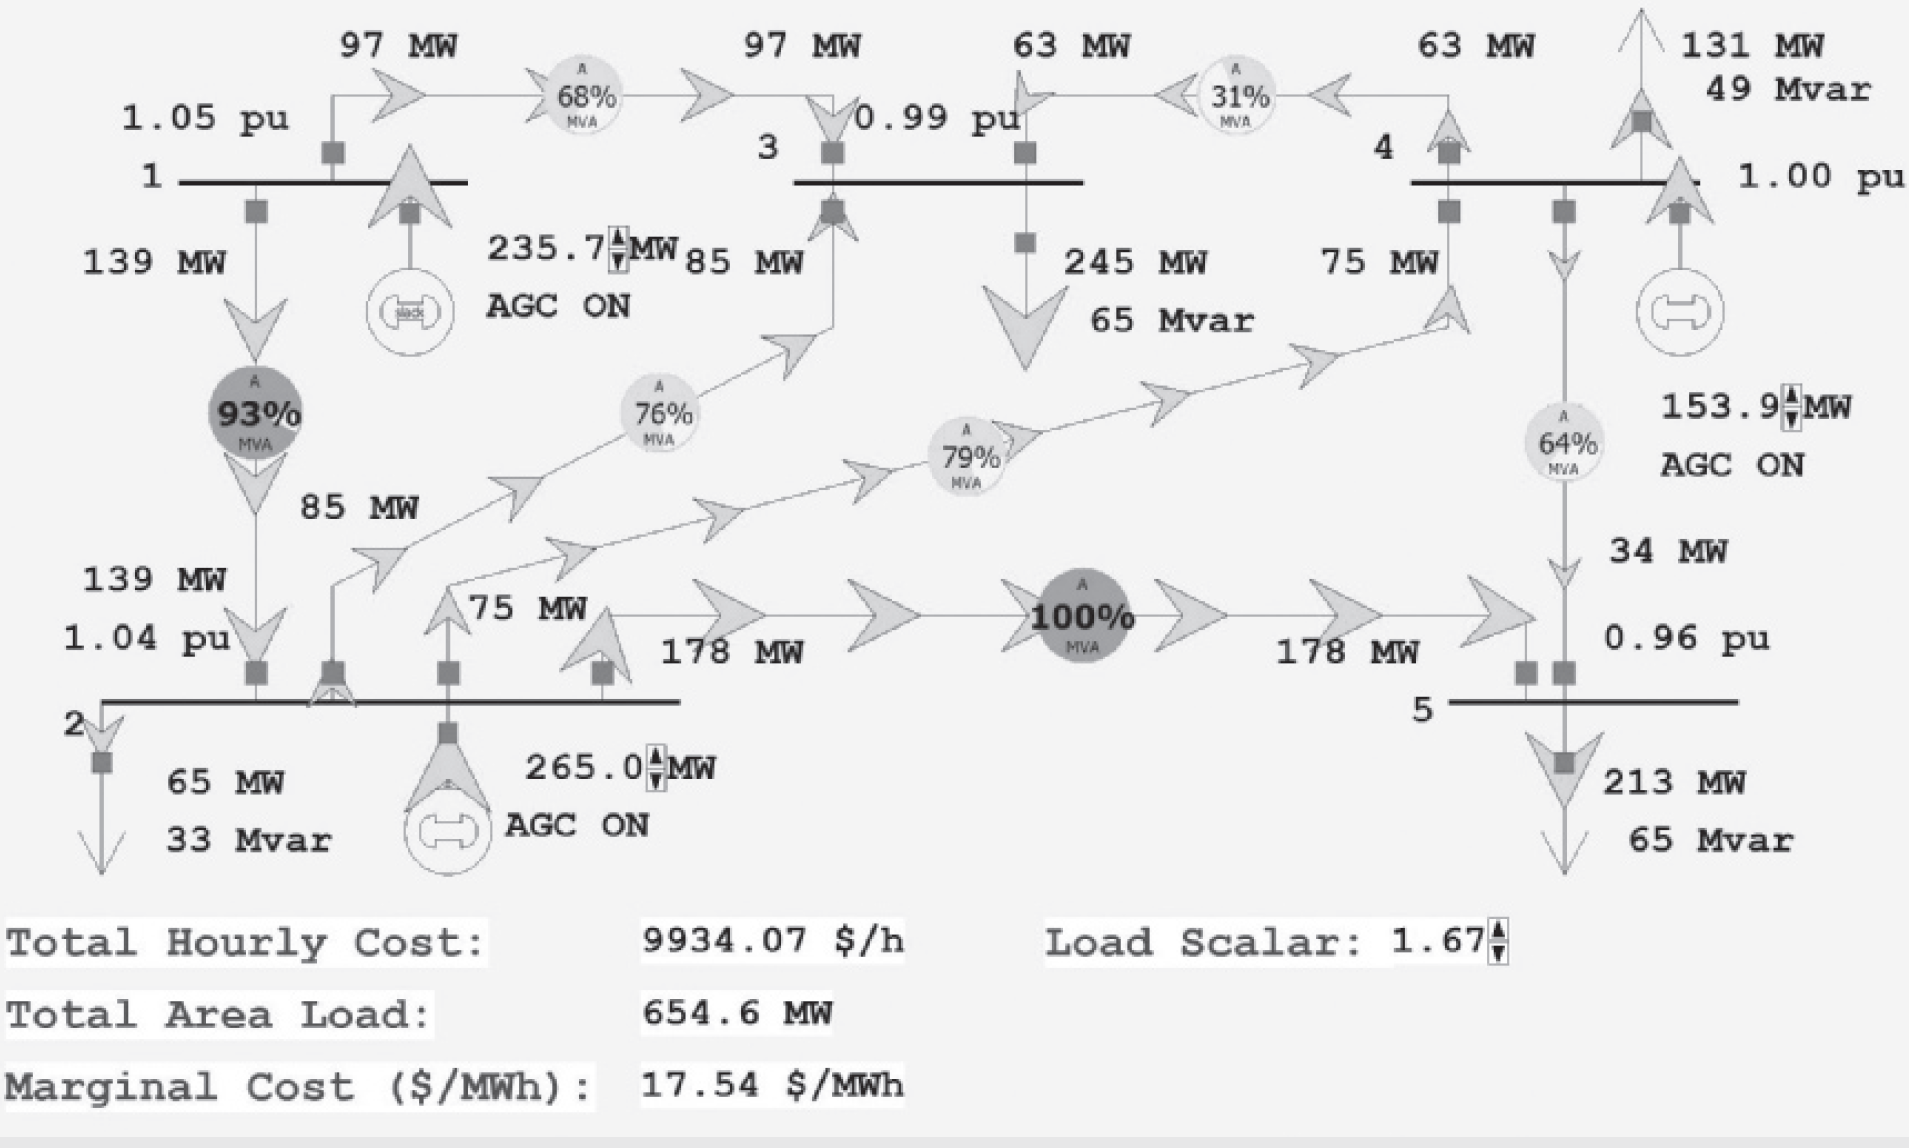

In [1]:
import pandas as pd
import numpy as np
import pandapower as pp
import pandapower.plotting as plot
from numpy import pi, sqrt
import os
import matplotlib.pyplot as plt
from pandas import DataFrame

Building the system, buses and lines 

In [2]:
# boundaries:
vm_max = 1.05
vm_min = 0.95

In [3]:
net = pp.create_empty_network(f_hz=60)

In [4]:
b1 = pp.create_bus(net, max_vm_pu=vm_max, min_vm_pu=vm_min, vn_kv=345, name="bus1", type="b")
b2 = pp.create_bus(net, max_vm_pu=vm_max, min_vm_pu=vm_min, vn_kv=345, name="bus2", type="b")
b3 = pp.create_bus(net, max_vm_pu=vm_max, min_vm_pu=vm_min, vn_kv=345, name="bus3", type="b")
b4 = pp.create_bus(net, max_vm_pu=vm_max, min_vm_pu=vm_min, vn_kv=345, name="bus4", type="b")
b5 = pp.create_bus(net, max_vm_pu=vm_max, min_vm_pu=vm_min, vn_kv=345, name="bus5", type="b")

In [5]:
pp.create_gen(net, bus=b1, controllable=True, p_mw=235.7, min_p_mw=100, max_p_mw=400, vm_pu=1.05, name="gen1", slack=True)
pp.create_gen(net, bus=b2, controllable=True, p_mw=265, min_p_mw=150, max_p_mw=500, vm_pu=1.04, name="gen2") 
pp.create_gen(net, bus=b4, controllable=True, p_mw=153.9, min_p_mw=50, max_p_mw=300, vm_pu=1, name="gen3") 

# pp.create_gen(net, bus=b1, controllable=False, p_mw=235.7, min_p_mw=100, max_p_mw=400, vm_pu=1.05, name="gen1", slack=True)
# pp.create_gen(net, bus=b2, controllable=False, p_mw=265, min_p_mw=150, max_p_mw=500, vm_pu=1.04, name="gen2") 
# pp.create_gen(net, bus=b4, controllable=False, p_mw=153.9, min_p_mw=50, max_p_mw=300, vm_pu=1, name="gen3") 


2

In [6]:
costeg1=pp.create_poly_cost(net, 0, 'gen', cp0_eur=0, cp1_eur_per_mw=10, cp2_eur_per_mw2=0.016)      
costeg2=pp.create_poly_cost(net, 1, 'gen', cp0_eur=0, cp1_eur_per_mw=8, cp2_eur_per_mw2=0.018)        
costeg3=pp.create_poly_cost(net, 2, 'gen', cp0_eur=0, cp1_eur_per_mw=12, cp2_eur_per_mw2=0.018)        

In [7]:
pp.create_load(net, bus=b2, p_mw=65, q_mvar=33, name="Load")
pp.create_load(net, bus=b3, p_mw=245, q_mvar=65, name="Load")
pp.create_load(net, bus=b4, p_mw=131, q_mvar=49, name="Load")
pp.create_load(net, bus=b5, p_mw=213, q_mvar=65, name="Load")

3

In [8]:
LS=1.67   #load Scalar
# LS=1.01
# LS=1.1
# LS=1.2

net.load.scaling=1/LS
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Load,1,65.0,33.0,0.0,0.0,NaN,0.598802,True,wye
1,Load,2,245.0,65.0,0.0,0.0,NaN,0.598802,True,wye
2,Load,3,131.0,49.0,0.0,0.0,NaN,0.598802,True,wye
3,Load,4,213.0,65.0,0.0,0.0,NaN,0.598802,True,wye


### Covert the parameters of lines from per unit values to actual values

In [9]:
Sb=100
Zb=345**2/Sb

R12=0.02*Zb;  X12=0.06*Zb;  B12=0.03*2/Zb;  C12=B12/(2*pi*net.f_hz)*1e9
R13=0.08*Zb;  X13=0.24*Zb;  B13=0.025*2/Zb;  C13=B13/(2*pi*net.f_hz)*1e9
R23=0.06*Zb;  X23=0.18*Zb;  B23=0.020*2/Zb;  C23=B23/(2*pi*net.f_hz)*1e9
R24=0.06*Zb;  X24=0.18*Zb;  B24=0.020*2/Zb;  C24=B24/(2*pi*net.f_hz)*1e9
R25=0.04*Zb;  X25=0.12*Zb;  B25=0.015*2/Zb;  C25=B25/(2*pi*net.f_hz)*1e9
R34=0.01*Zb;  X34=0.03*Zb;  B34=0.010*2/Zb;  C34=B34/(2*pi*net.f_hz)*1e9
R45=0.08*Zb;  X45=0.24*Zb;  B45=0.025*2/Zb;  C45=B45/(2*pi*net.f_hz)*1e9

# Ik=1200e6/(sqrt(3)*345e3)/1000

In [10]:
L12=pp.create_line_from_parameters(net, from_bus=b1, to_bus=b2, length_km=1, 
                               name="Line 1-2", r_ohm_per_km= R12, x_ohm_per_km=X12, 
                               c_nf_per_km=C12, max_i_ka=1e9)
L13=pp.create_line_from_parameters(net, from_bus=b1, to_bus=b3, length_km=1, 
                               name="Line 1-3", r_ohm_per_km= R13, x_ohm_per_km=X13,  
                               c_nf_per_km=C13, max_i_ka=1e9)
L23=pp.create_line_from_parameters(net, from_bus=b2, to_bus=b3, length_km=1, 
                               name="Line 2-3", r_ohm_per_km= R23, x_ohm_per_km=X23, 
                               c_nf_per_km=C23, max_i_ka=1e9)
L24=pp.create_line_from_parameters(net, from_bus=b2, to_bus=b4, length_km=1, 
                               name="Line 2-4",  r_ohm_per_km= R24, x_ohm_per_km=X24, 
                               c_nf_per_km=C24, max_i_ka=1e9)
L25=pp.create_line_from_parameters(net, from_bus=b2, to_bus=b5, length_km=1, 
                               name="Line 2-5", r_ohm_per_km= R25, x_ohm_per_km=X25, 
                               c_nf_per_km=C25, max_i_ka=1e9)
L34=pp.create_line_from_parameters(net, from_bus=b3, to_bus=b4, length_km=1, 
                               name="Line 3-4", r_ohm_per_km= R34, x_ohm_per_km=X34, 
                               c_nf_per_km=C34, max_i_ka=1e9)
L45=pp.create_line_from_parameters(net, from_bus=b4, to_bus=b5, length_km=1, 
                               name="Line 4-5", r_ohm_per_km= R45, x_ohm_per_km=X45, 
                               c_nf_per_km=C45, max_i_ka=1e9)

In [11]:
net

This pandapower network includes the following parameter tables:
   - bus (5 elements)
   - load (4 elements)
   - gen (3 elements)
   - line (7 elements)
   - poly_cost (3 elements)

In [12]:
pp.runpp(net)

In [13]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.050000,0.000000,18.060413,-44.859906
1,1.040000,1.676878,-226.077844,-30.133958
2,0.990022,-2.411341,146.706587,38.922156
3,1.000000,-1.082580,-75.456886,-0.708911
4,0.956800,-4.631435,127.544910,38.922156


In [14]:
Ybs=(round(net['_ppc']['internal']['Ybus'],5))
# print(Ybs)

In [15]:
pp.runopp(net, verbose=True)

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.35 seconds
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              5     Total Gen Capacity    1200.0       -3000000000.0 to 3000000000.0
Generators         3     On-line Capacity      1200.0       -3000000000.0 to 3000000000.0
Committed Gens     3     Generation (actual)    403.7             132.5
Loads              4     Load                   391.6             126.9
  Fixed            4       Fixed                391.6             126.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches           7     Losses (I^2 * Z)        12.08         

In [16]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar,lam_p,lam_q
0,1.049999,0.000000,-129.035897,26.968542,14.129141,-1.528230e-20
1,1.049972,-2.450791,-142.729048,-57.223697,14.539436,4.053781e-20
2,1.011971,-7.453486,146.706587,38.922156,15.463759,1.066025e-01
3,1.027056,-7.011888,-14.563695,-53.161700,15.348240,4.171926e-20
4,0.973433,-9.192321,127.544910,38.922156,15.928778,4.400977e-01


In [17]:
net.res_gen

,p_mw,q_mvar,va_degree,vm_pu
0,129.035897,-26.968542,0.000000,1.049999
1,181.651203,76.984176,-2.450791,1.049972
2,93.006808,82.503017,-7.011888,1.027056
